In [43]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [44]:
zip_file_path = "Face Data for Homework.zip"

extract_path = "face_images"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [58]:
#!ls /content/face_images/ATT

In [46]:
data_path = "/content/face_images/ATT"

images = []
labels = []

for image_name in sorted(os.listdir(data_path)):
        image_path = os.path.join(data_path, image_name)
        if os.path.isfile(image_path) and image_name.lower().endswith(".png"):
            image = Image.open(image_path)
            images.append(np.asarray(image, dtype=np.float32))
            labels.append(image_name.split('_')[0])


images = np.array(images)
labels = np.array(labels)

print(images.shape)
print(labels.shape)


(400, 112, 92)
(400,)


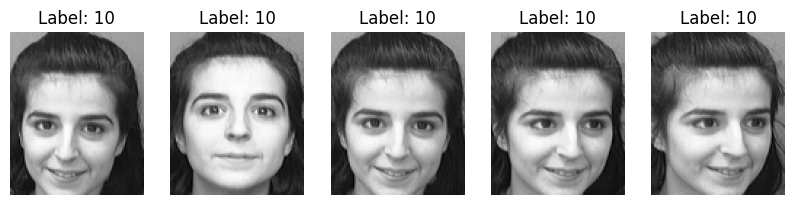

In [47]:
num_samples = 5

plt.figure(figsize=(10, 5))
for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
plt.show()

In [48]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [49]:
# KNN

def knn(train_data, train_labels, test_data):

    predictions = []
    for test_point in test_data:
        distances = []

        for train_point in train_data:
            distances.append(euclidean_distance(test_point, train_point))

        nn_index = np.argmin(distances)
        predictions.append(train_labels[nn_index])

    return np.array(predictions)

# **Task 1**

In [50]:
def cross_validate(images, labels, n_splits=5):

    fold_size = len(images) // n_splits
    indices = np.arange(len(images))
    np.random.seed(42)
    np.random.shuffle(indices)

    accuracies = []

    for i in range(n_splits):
        test_idx = indices[i * fold_size:(i + 1) * fold_size]
        train_idx = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        train_data, test_data = images[train_idx], images[test_idx]
        train_labels, test_labels = labels[train_idx], labels[test_idx]


        train_data = train_data.reshape(train_data.shape[0], -1)
        test_data = test_data.reshape(test_data.shape[0], -1)

        # Predicting using KNN
        predictions = knn(train_data, train_labels, test_data)

        accuracy = np.mean(predictions == test_labels)
        accuracies.append(accuracy)

        print(f"Fold {i+1} accuracy: {accuracy:.4f}")

    # Average accuracy
    average_accuracy = np.mean(accuracies)
    print(f"Average accuracy across {n_splits} folds: {average_accuracy:.4f}")
    return average_accuracy


In [51]:
cross_validate(images,labels)

Fold 1 accuracy: 0.9625
Fold 2 accuracy: 0.9375
Fold 3 accuracy: 0.9500
Fold 4 accuracy: 0.9500
Fold 5 accuracy: 0.9500
Average accuracy across 5 folds: 0.9500


0.95

# **Task 2**

In [52]:
def center_data(data):

    mean_image = np.mean(data, axis=0)
    return data - mean_image, mean_image

In [53]:
def pca(data):

    U, S, Vt = np.linalg.svd(data, full_matrices=False)

    principal_components = Vt[:100]

    reduced_data = np.dot(data, principal_components.T)

    return reduced_data, principal_components

In [54]:
def cross_validate_pca(images, labels, n_splits=5):


    fold_size = len(images) // n_splits
    indices = np.arange(len(images))
    np.random.seed(42)
    np.random.shuffle(indices)

    accuracies = []

    for i in range(n_splits):
        test_idx = indices[i * fold_size:(i + 1) * fold_size]
        train_idx = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        train_data, test_data = images[train_idx], images[test_idx]
        train_labels, test_labels = labels[train_idx], labels[test_idx]


        train_data = train_data.reshape(train_data.shape[0], -1)
        test_data = test_data.reshape(test_data.shape[0], -1)


        train_data_centered, mean_image = center_data(train_data)
        test_data_centered = test_data - mean_image

        # Perform PCA
        train_data_pca, principal_components = pca(train_data_centered)
        test_data_pca = np.dot(test_data_centered, principal_components.T)

        # Predict using KNN
        predictions = knn(train_data_pca, train_labels, test_data_pca)

        accuracy = np.mean(predictions == test_labels)
        accuracies.append(accuracy)

        print(f"Fold {i+1} accuracy: {accuracy:.4f}")


    average_accuracy = np.mean(accuracies)
    print(f"Average accuracy across {n_splits} folds: {average_accuracy:.4f}")
    return average_accuracy

In [55]:
cross_validate_pca(images,labels)

Fold 1 accuracy: 0.9625
Fold 2 accuracy: 0.9500
Fold 3 accuracy: 0.9250
Fold 4 accuracy: 0.9500
Fold 5 accuracy: 0.9500
Average accuracy across 5 folds: 0.9475


0.9475000000000001

# **Task 3**

In [56]:
def resize_images(images, new_size):

    resized_images = []
    for image in images:
        resized_image = Image.fromarray(image).resize(new_size)
        resized_images.append(np.asarray(resized_image, dtype=np.float32))
    return np.array(resized_images)

resized_images = resize_images(images, new_size=(56, 46))

In [57]:
# Resized Images
print("\nResults for resized images (56x46):")
accuracy_resized = cross_validate_pca(resized_images, labels)

# Original Images
print("\nResults for original images (112x92):")
accuracy_original = cross_validate_pca(images, labels)


print(f"\nComparison of results:")
print(f"Accuracy with original images (112x92): {accuracy_original:.4f}")
print(f"Accuracy with resized images (56x46): {accuracy_resized:.4f}")


Results for resized images (56x46):
Fold 1 accuracy: 0.9625
Fold 2 accuracy: 0.9625
Fold 3 accuracy: 0.9625
Fold 4 accuracy: 0.9500
Fold 5 accuracy: 0.9500
Average accuracy across 5 folds: 0.9575

Results for original images (112x92):
Fold 1 accuracy: 0.9625
Fold 2 accuracy: 0.9500
Fold 3 accuracy: 0.9250
Fold 4 accuracy: 0.9500
Fold 5 accuracy: 0.9500
Average accuracy across 5 folds: 0.9475

Comparison of results:
Accuracy with original images (112x92): 0.9475
Accuracy with resized images (56x46): 0.9575
